In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io import loadmat
import random
import pandas as pd


In [13]:
# Defining parameters

student_number = 5381827
student_number = list(str(student_number))
for i in range(len(student_number)):
    student_number[i] = int(student_number[i])
A, B, C, D, E, F, G = student_number


g = 9.81                    # Gravitational acceleration [m/s^2]
xi = 0.040 + C * 1e-3       # Damping ratio []
PGA = (0.33 + D * 1e-2)     # Peak ground acceleration [g]
gamma = 1.4                 # Importance factor [] - Importance class IV (assigned) corresponds to gamma=1.4 according to EN1998-1-1 (par 4.2.5)
a_g_ref = PGA*gamma         # Horizontal Reference acceleration [g] - Type 2 Earthquake (M_s = 5.0, assigned parameter)
a_vg_ref = a_g_ref*0.45     # Vertical Reference acceleration [g] - Type 2 Earthquake (M_s = 5.0, assigned parameter)

print(f"Damping ration: {xi:.3}")
print(f"Peak Ground Acceleration (excluding importance factor): {PGA*g} m/s^2")
print(f"Horizontal Reference Acceleration for EN1998-1: {a_g_ref*g} m/s^2")
print(f"Vertical Reference Acceleration for EN1998-1: {a_vg_ref*g} m/s^2")

Damping ration: 0.048
Peak Ground Acceleration (excluding importance factor): 3.3354000000000004 m/s^2
Horizontal Reference Acceleration for EN1998-1: 4.66956 m/s^2
Vertical Reference Acceleration for EN1998-1: 2.101302 m/s^2


1.0101525445522108


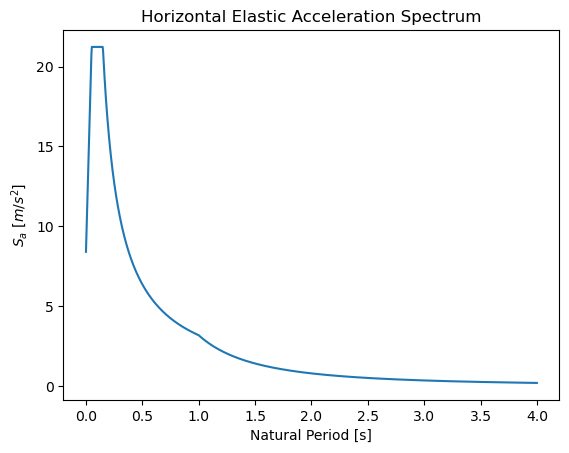

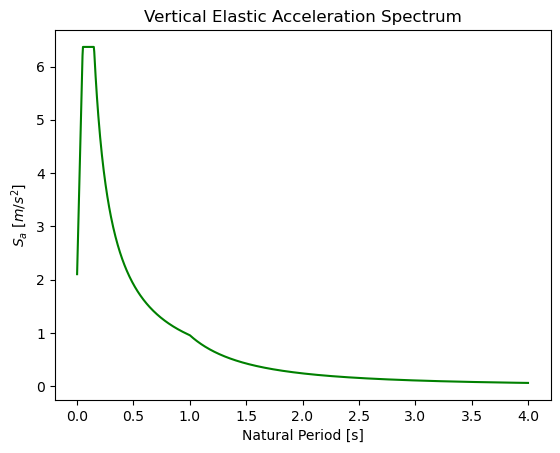

In [12]:
# Converting accelerations to m/s^2 for consistency with previous analysis
a_g_ref_ms2 = PGA*gamma*g        
a_vg_ref_ms2 = a_g_ref*0.45*g    

# Ground Type D - According to assignment input parameters

eta = np.sqrt(10/(5+xi*100))
print(eta)

S = 1.8
TB = 0.10
TC = 0.30
TD = 1.2
def horizontal_elastic_acc_spectrum(T, eta):
 Se_T_values = []
 for T in T:
   if 0 <= T <= TB:
      Se_T = a_g_ref_ms2 * S * (1 + (T / TB) * (eta * 2.5 - 1))
      Se_T_values.append(Se_T)
   elif TB < T <= TC:
      Se_T = a_g_ref_ms2 * S * eta * 2.5
      Se_T_values.append(Se_T)
   elif TC < T <= TD:
      Se_T = a_g_ref_ms2 * S * eta * 2.5 * (TC / T)
      Se_T_values.append(Se_T)
   elif TD < T <= 4.0:
      Se_T = a_g_ref_ms2 * S * eta * 2.5 * (TC * TD) / (T ** 2)
      Se_T_values.append(Se_T)
   else:
      Se_T = 0  # Or raise an exception or handle out-of-range T
      Se_T_values.append(Se_T)
 return Se_T_values


TB = 0.05 
TC = 0.15
TD = 1.0

def vertical_elastic_acceleration_response_spectrum(T, eta):
  Svd_T_values = []
  for T in T: 
      if 0 <= T <= TB:
           Svd_T = a_vg_ref_ms2 * (1 + (T / TB) * (eta * 3.0 - 1))
           Svd_T_values.append(Svd_T)
      elif TB < T <= TC:
          Svd_T = a_vg_ref_ms2 * eta * 3.0
          Svd_T_values.append(Svd_T)
      elif TC < T <= TD:
          Svd_T = a_vg_ref_ms2 * eta * 3.0 * (TC / T)
          Svd_T_values.append(Svd_T)
      elif TD < T:
          Svd_T = a_vg_ref_ms2 * eta * 3.0 * (TC * TD) / (T ** 2)
          Svd_T_values.append(Svd_T)
      else:
          Svd_T = 0  # Or handle as out-of-rang
          Svd_T_values.append(Svd_T)
  return Svd_T_values


T = np.linspace(0,4,1000)

plt.plot(T,horizontal_elastic_acc_spectrum(T,eta))
plt.title("Horizontal Elastic Acceleration Spectrum")
plt.xlabel(r'Natural Period [s]')
plt.ylabel(r'$S_a$ [$m/s^2$]')
plt.show()

plt.plot(T,vertical_elastic_acceleration_response_spectrum(T,eta),color='g')
plt.title("Vertical Elastic Acceleration Spectrum")
plt.xlabel(r'Natural Period [s]')
plt.ylabel(r'$S_a$ [$m/s^2$]')
plt.show()

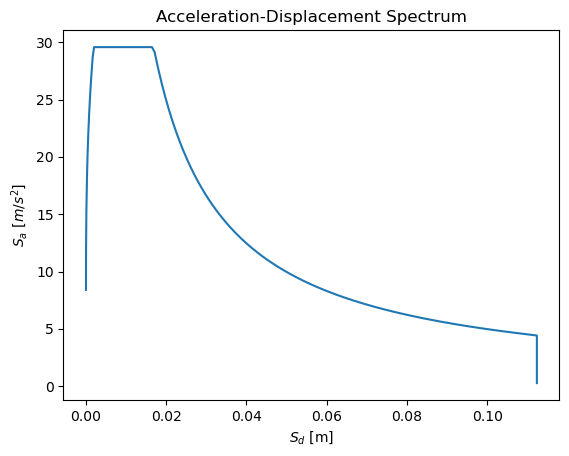

In [ ]:
# Acceleration-Displacement Response Spectrum

S_a_hor_ms = g*np.array(horizontal_elastic_acc_spectrum(T, eta))
S_d_hor_ms = [T[i]**2*S_a_hor_ms[i]/(4*np.pi**2) for i in range(len(T))]

plt.plot(S_d_hor_ms,S_a_hor_ms)
plt.title("Horizontal Acceleration-Displacement Spectrum")
plt.xlabel(r'$S_d$ [m]')
plt.ylabel(r'$S_a$ [$m/s^2$]')
plt.show()

# Question 3.a
The pushover method of analysis is based on the imposition of a displacement pattern based either on uniform or modal deformed state. The standard operational procedure given by Eurocode 1998-1 begins with the derivation of the elastic spectrum based on a limited number of parameters that aim at predicting both Earthquake excitation and soil behavior. The first potential inconsistency when dealing with the Groningen seismic activity is that vertical accelerations are dominant in artificially induced Earthquakes, whereas the code assumes lateral excitations to be the critical design case (as can be seen in the coefficient table at 3.2.2.3 of EN1998-1). This particular feature is also relevant for the appropriate choice of mode to be used in the application of the modal displacement pattern. The pushover method relies on the ability of the single selected mode to describe the structural response to the excitation. In the case of the structure of interest the most critical loading condition is expected to be caused by lateral excitations, well represented by mode 1 and 2. These modes are however not able to represent properly the vertical component which is expected to be dominant in an Earthquake from the Groningen region. More generally, such considerations are especially relevant for structures whose stiffness relies on self-weight (i.e. a masonry structure with a disconnected roof). Another feature that may be relevant depending on the structure under analysis is that artificially induced earthquakes are characterized by high-energy release at higher frequencies, which may be relevant for the appropriate selection of modal pattern and is particularly important for short-period structures.

# Question 3.b
![image](Figures/3b_demand_vs_capacity_spectrum.png)

Our structure is able to withstand the acceleration imposed by EN1998-1 standard within its elastic regime. According to the simulation no plastic response is developed within failure. The failure peak acceleration would then amount to #?

# Question 3.c

According to EN1998-1-2005 section 4.3.3.2.1 a single mode approximation is a viable option when the period of the chosen mode of vibration satisfies the following conditions:
$$
T_n<
\begin{cases}
4*T_C \\
2s
\end{cases}
$$
In our design scenario $T_C=0.3s$ and $4*T_C=1.2s$. Mode 2 was chosen for the analysis in X direction and respects the above mentioned condition with $T_2=0.27 s$. Mode 1 was chosen for the analysis in Y direction with $T_5=0.27 s$. No further load combinations are therefore deemed necessary.

## Question 4 - Time History Analysis
A Time History Analysis was carried out as part of the seismic assessment of the structure. Signal 1 was chosen from previously processed data and the model was subjected to the derived accelerations in the three principal directions.  
As part of this analysis a limitation of the RFEM software was encountered: the Stress-Analysis module did not support nonlinear material behavior for members. As a consequence the analysis was carried out in both bilinear and linear regimes, but stresses were computed for linear regime. It is therefore implicitly assumed that the linear behavior of the structure is sufficient to identify critical stresses location.

The comparison of **maximum displacements** yielded the following results:
|DOF|Member|Material Bilinear|Material Linear|
|:-:|:-:|:-:|:-:|
|X|313|-83.5 mm | -83.3 mm |
|Y|365|87.0 mm |  86.3 mm |
|Z|329|-19.3 mm |  17.9 mm |
|$\phi_x$|365|41.7 mrad |41.0 mrad |
|$\phi_y$|329|-18.4 mrad |17.5 mrad |
|$\phi_z$|119|-70.3 mrad |-70.6 mrad |

**Most relevant high stresses locations**:
| Member No. | Location x [m] | Stress Existing [N/mm2] | Stress Limit [N/mm2] | Stress Ratio $\eta$ [-] |
| :---------: | :--------------: | :----------------------:| :------------------: | :----------------: |
| 111        | 1.874          | 200.340                 | 235.000              | 0.853              |
| 117        | 0.000          | 201.047                 | 235.000              | 0.856              |
| 311        | 1.707          | 211.905                 | 235.000              | 0.902              |
| 312        | 0.000          | 215.914                 | 235.000              | 0.919              |
| 329        | 0.000          | 258.318                 | 235.000              | 1.099              |
| 331        | 1.354          | 258.399                 | 235.000              | 1.100              |

![THA - Critical Stresses Members](Figures/THA_critical_elements.png)

Displayed stresses were computed with Von Mises equivalent stresses criterion. Comparing stresses with yielding stress values for the chosen material it is apparent how most critical excitation is located at the interface between Members 329-331. 
This is consistent with Spectral and Modal analysis results. Mode 41, which excites precisely the members of interest as shown in the following figure, has in fact a period of $0.065 s$ which closely matches the peak frequency of the vertical component of the Elastic Response Spectrum computed for the chosen signal.

<div style="display: flex; flex-wrap: wrap; justify-content: space-around;">
  <img src="Figures/THA_def_mode41.png" alt="Mode 41 Def" style="width: 30%;">
  <img src="Figures/THA_signal1_mode41.png" alt="Mode 41 - ERS" style="width: 30%;">
</div>
<br>

[To be completed]
Conclusion (about seismic capacity of the structure):


# Question 5.a
<div style="display: flex; flex-wrap: wrap; justify-content: space-around;">
  <img src="Figures/MA_1.png" alt="Mode 1" style="width: 20%;">
  <img src="Figures/MA_2.png" alt="Mode 2" style="width: 20%;">
  <img src="Figures/MA_3.png" alt="Mode 3" style="width: 20%;">
  <img src="Figures/MA_4.png" alt="Mode 4" style="width: 20%;">
  <img src="Figures/MA_5.png" alt="Mode 5" style="width: 20%;">
</div>
<br>

| Mode Nr |NF| Modal Mass | EMM X | EMM Y | EMM Z | EMM $\phi_x$ | EMM $\phi_y$ | EMM $\phi_z$ | Factor X | Factor Y | Factor Z | Factor $\phi_X$ | Factor $\phi_Y$ | Factor $\phi_Z$ |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| 1 | | 3389.1 | 4256.0 | 165.0 | 40.9 | 5109.52 | 27803.70 | 300411.00 | 0.100 | 0.004 | 0.001 | 0.007 | 0.036 | 0.615 |
| 2 | | 53.1 | 0.1 | 0.2 | 116.5 | 1270.95 | 0.00 | 7.61 | 0.000 | 0.000 | 0.003 | 0.002 | 0.000 | 0.000 |
| 3 | | 44.6 | 26.8 | 35.8 | 182.0 | 1967.62 | 1709.62 | 3276.87 | 0.001 | 0.001 | 0.004 | 0.003 | 0.002 | 0.007 |
| 4 | | 7730.7 | 24739.0 | 24.8 | 0.1 | 388.16 | 177138.00 | 51359.90 | 0.583 | 0.001 | 0.000 | 0.001 | 0.227 | 0.105 |
| 5 | | 4714.2 | 0.4 | 28607.5 | 2.8 | 200346.00 | 1.84 | 2940.40 | 0.000 | 0.674 | 0.000 | 0.260 | 0.000 | 0.006 |

Inspecting the results of the modal analysis we can see that the most relevant mode is mode 5 with a modal mass factor of 0.67 in for translational y-direction and 0.26 rotational-x direction.This mode will be the most relevant in describing the behavior in the x-direction. However mode 4 is also relevant with a modal mass factor of 0.58 in for translational x-direction and 0.22 rotational-y direction. The similarity in properties between the two modes is to be expected as a result of the highly symmetric geometry of the structure. Moreover mode 1 is relevant in describing the torsional behavior of the structure with a modal mass factor of 0.61 in the rotational-z direction.

# Question 5.b

|Critical Section|$U_x$|$U_y$|$U_z$|$\phi_x$|$\phi_y$|$\phi_z$|$\sigma_x$|$\sigma_y$|$\sigma_z$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
||||||||||
||||||||||
||||||||||
||||||||||

Since our modal frequencies are closely spaced (see table in asnwer 5.a) CQC method was preferred to the SRSS rule to combine structural modes. A damping ratio of 5% was assumed as realistic for all modes, therefore we are outside of the range of inaccuracy of the CQC method. Given the EN1998-1 spectra wide band range CQC was also deemed more appropriate to the specific design situation.

SRSS was then selected to combined different directional seismic components. This method was preferred to the follwing alternatives: 
- the absolute sum method was deemed over-conservative  
- the scaled sum method was discarded for its questionable approach to modelling the physical phenomenon.




# Question 5.c

The number of modes considered was first set to 10 and then increased to 75 in order to obtain a 90% sum of modal participation factors for X and Y directions.
The final choice of 75 #? returns the following cumulative sums:
|N Modes|X|Y|Z|$\phi_x$|$\phi_y$|$\phi_z$|
||:-:|:-:|:-:|:-:|:-:|:-:|
||93.22|91.99|29.04|73.60|77.60|93.54|

The chosen truncation does not return a satisfying compound modal participation factor in the translational Z direction as well as rotational X and Y directions. As such the resulting 

